# Plot Histogram of Newton Update Ratio: $\delta \rho / \sum_i^N \delta (\rho X_i)$

To use this, insert the following code into `sdc_util.F90` after the calculation of `dU_react` in the Newton iterations:

```
print *, 'delta_rho_ratio: ', dU_react(0)/sum(dU_react(1:nspec_evolve))
```

Then run in serial and redirect output to a `run.log` file.

In [1]:
import numpy as np
import re
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Read console output from `run.log`

In [2]:
lines = []
f = open('run.log', 'r')
for l in f:
    lines.append(l.strip())
f.close()
lines.reverse()

steps = []
step_numbers = []

delta_re = re.compile('\Adelta_rho_ratio: (.*)\Z')
timestep_re = re.compile('\A\[Level [0-9]+ step ([0-9]+)\] ADVANCE .*\Z')

this_step = []
for l in lines:
    delta_m = delta_re.match(l)
    if delta_m:
        this_step.append(float(delta_m.group(1)))
        continue
    timestep_m = timestep_re.match(l)
    if timestep_m:
        steps.append(this_step)
        step_numbers.append(int(timestep_m.group(1)))
        this_step = []
        
steps.reverse()
step_numbers.reverse()

## Get per step and cumulative counts

In [3]:
# "before_last" is the cumulative counts for all steps except the last
before_last = []
if len(steps) > 1:
    for s in steps[:-1]:
        before_last += s

before_last = np.array(before_last)

# "last_step" is the counts for the last step
last_step = np.array(steps[-1])

data_step_number = []
data_delta_ratio = []
data_weights = []

for sn, s in zip(step_numbers, steps):
    for srat in s:
        # manually eliminate entries outside of [-1.5, 1.5]
        if srat < 1.5 and srat > -1.5:
            data_step_number.append(sn)
            data_delta_ratio.append(srat)
            # normalize per step for the 2D histogram
            data_weights.append(1.0/len(s))
            
data_step_number = np.array(data_step_number)
data_delta_ratio = np.array(data_delta_ratio)
data_weights = np.array(data_weights)

## Plot Histograms

The first plot shows each step, where the counts are normalized per-step.

The second plot shows the cumulative counts for all steps except the last step.

The third plot shows the counts for the last step.

/usr/lib64/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/lib64/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/usr/lib64/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


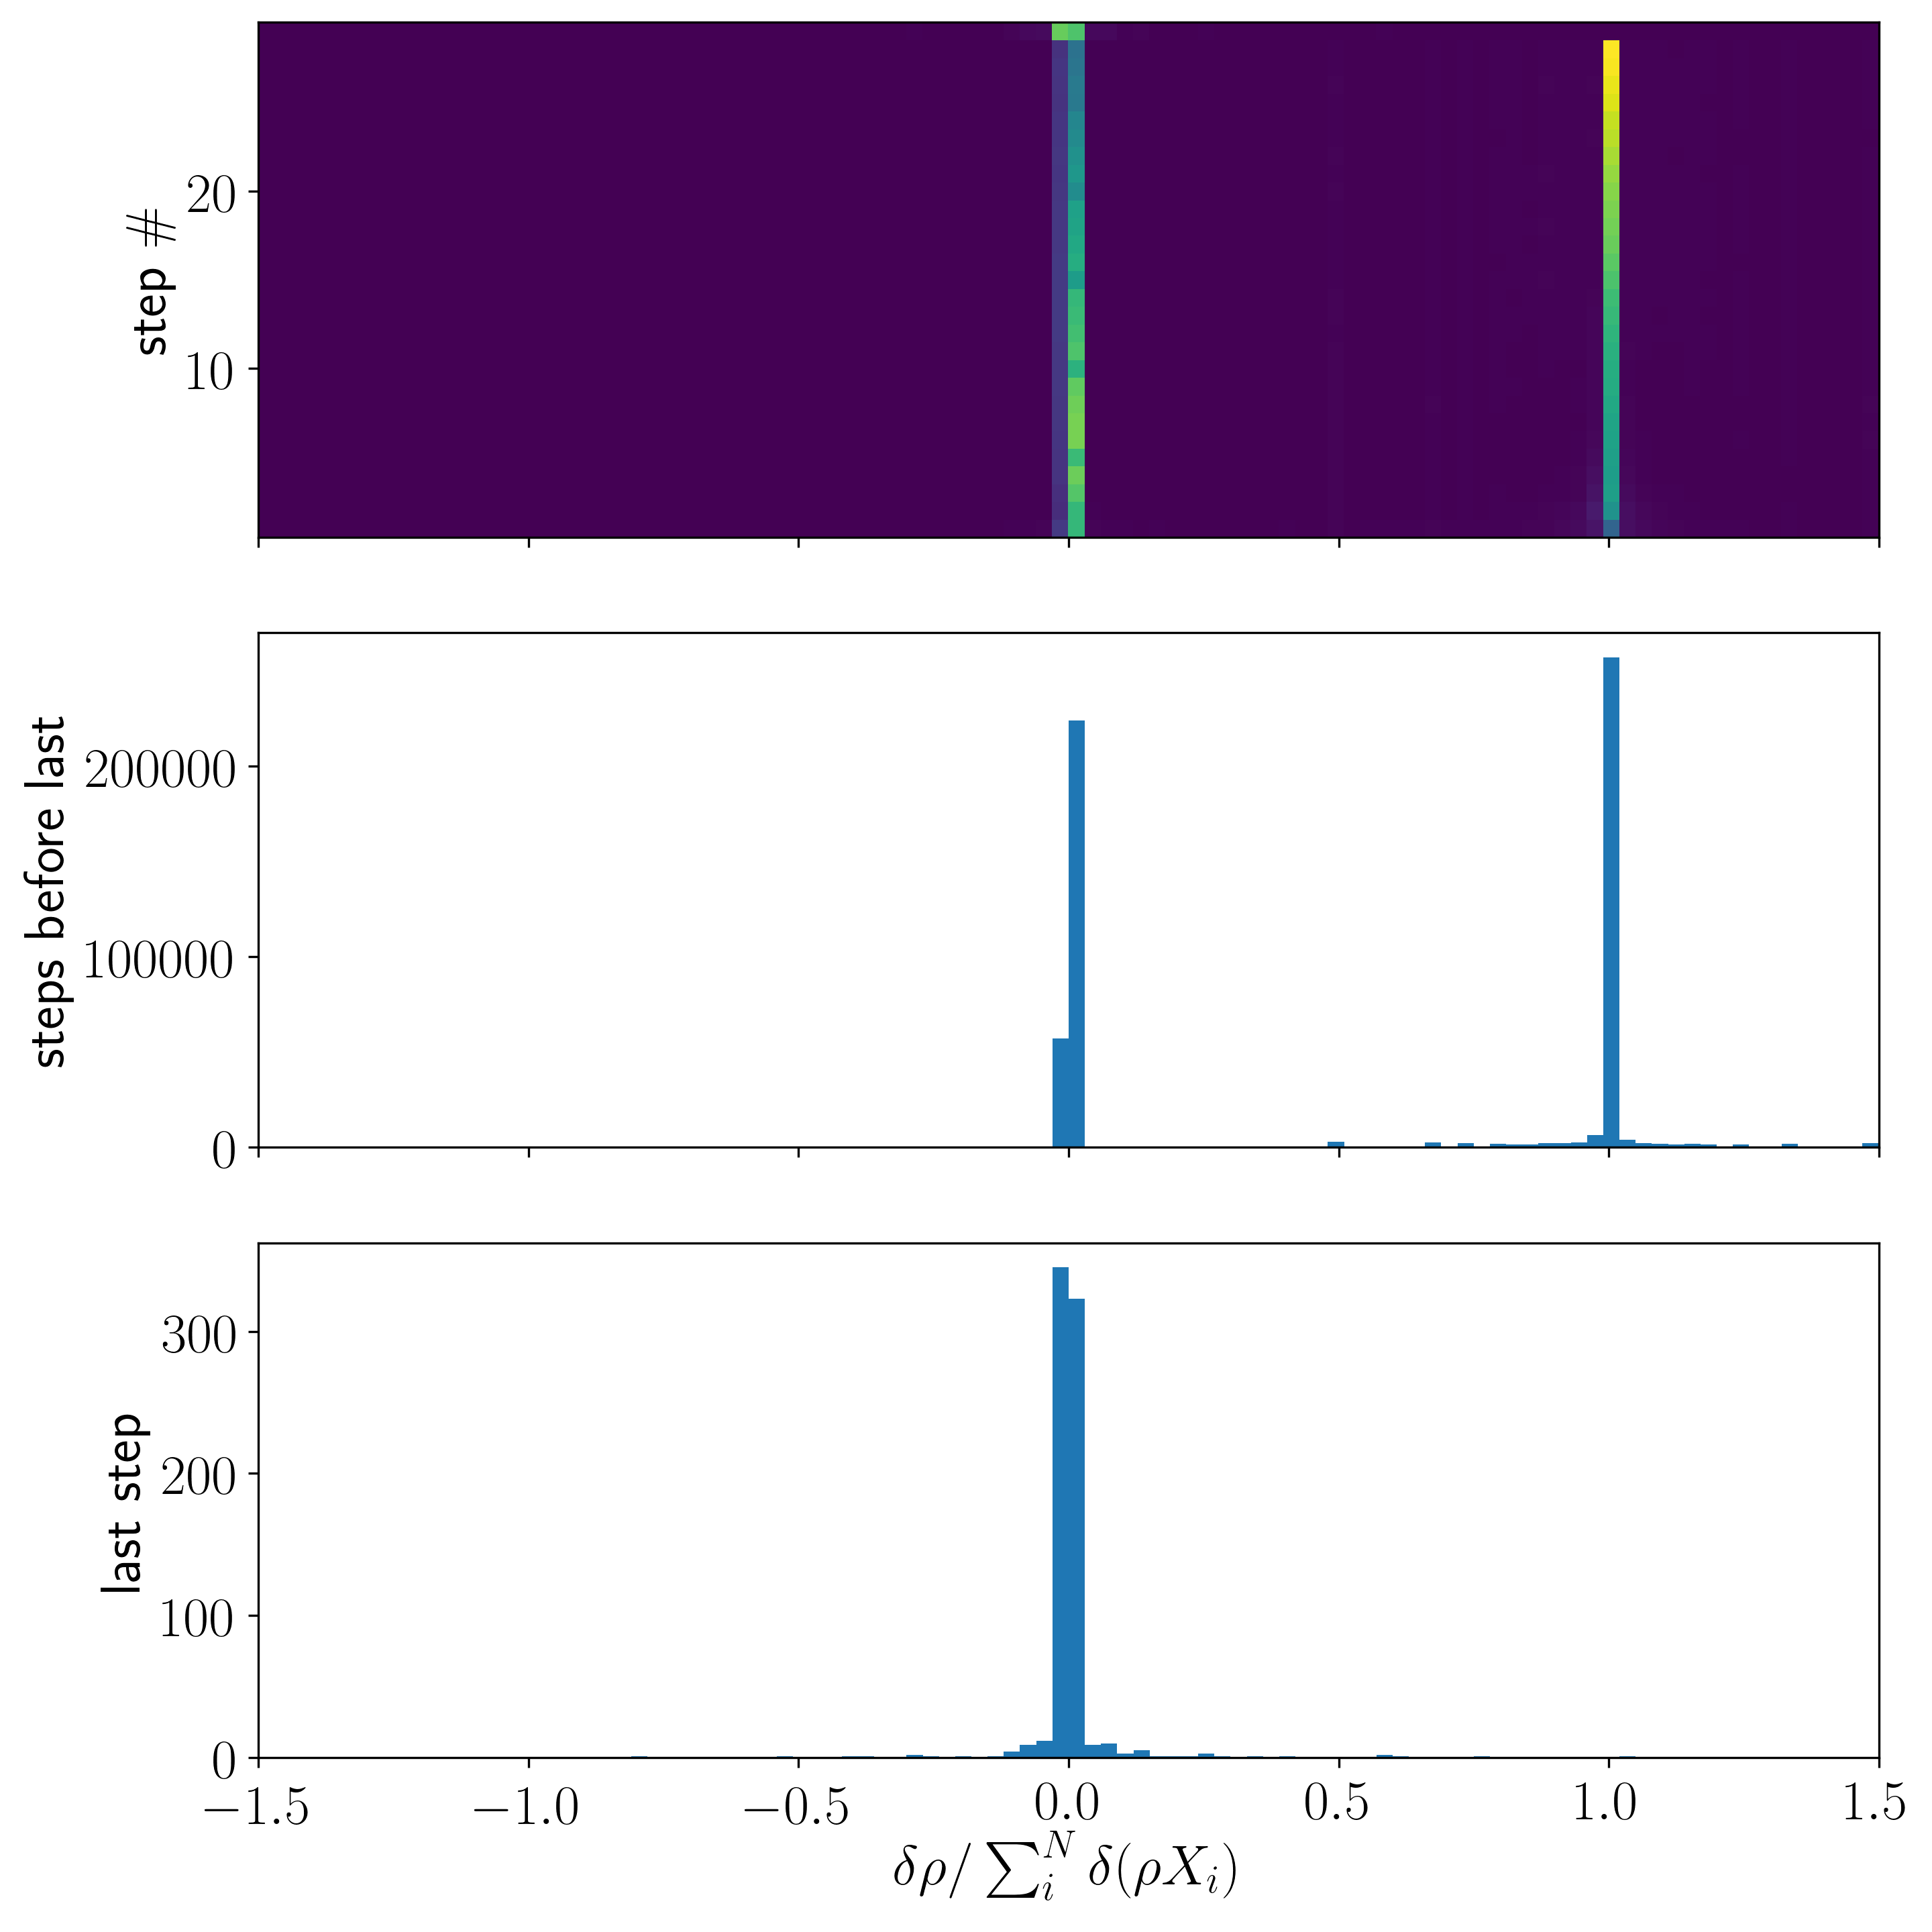

In [4]:
font_config = {'size': 20}
text_config = {'usetex': True}
figure_config = {'dpi': 300}
matplotlib.rc('font', **font_config)
matplotlib.rc('text', **text_config)
matplotlib.rc('figure', **figure_config)

nbins = 100

fig, ax = plt.subplots(3, 1, sharex=True, tight_layout=True)

fig.set_figheight(10.0)
fig.set_figwidth(10.0)

step_bin_edges = np.linspace(step_numbers[0]-0.5, step_numbers[-1]+0.5, num=len(step_numbers)+1)
ratio_bin_edges = np.linspace(-1.5, 1.5, num=nbins+1, endpoint=True)
ax[0].hist2d(data_delta_ratio, data_step_number, bins=(ratio_bin_edges, step_bin_edges), weights=data_weights)
ax[0].set_ylabel('step \#')

ax[1].hist(before_last, bins=nbins, range=[-1.5, 1.5])
ax[1].set_ylabel('steps before last')

ax[2].hist(last_step, bins=nbins, range=[-1.5, 1.5])
ax[2].set_ylabel('last step')
ax[2].set_xlabel('$\delta \\rho / \sum_i^N \delta (\\rho X_i)$')

plt.savefig('delta_rho_ratio.png', dpi=300)